# Assignment 1

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

Define constants and training parameters:

In [16]:
DATASET_PATH = './data'

BATCH_SIZE = 1024
SHUFFLE_TRAIN = True

NUM_EPOCHS = 100

## Task 1

Train and compare the following models on the CIFAR-10 dataset (available in PyTorch). The models should have slightly optimized parameters to try to maximize their performance.

### Load dataset

In [17]:
train_dataset = datasets.CIFAR10(root=DATASET_PATH, train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root=DATASET_PATH, train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=SHUFFLE_TRAIN
    )

eval_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        # drop_last=True
    )

### MLP

In [112]:
LR = 1e-3

INPUT_DIM = np.prod(train_dataset.data.shape[-3:]) # 32*32*3
OUTPUT_DIM = len(set(train_dataset.targets)) # 10

hidden_dim = int((INPUT_DIM + OUTPUT_DIM) * 2/3) # 2/3 rule
print(f"input dim={INPUT_DIM}, output dim={OUTPUT_DIM}, hidden={hidden_dim}")

input dim=3072, output dim=10, hidden=2054


In [113]:
from models import MLP, count_model_params

mlp = MLP(INPUT_DIM, hidden_dim, OUTPUT_DIM)
mlp = mlp.to(device)
count_model_params(mlp)

10553462

In [114]:
from train import train

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=LR)

mlp_losses = train(mlp, NUM_EPOCHS, train_loader, device, criterion, optimizer)

Epoch 55 Iteration 49: loss 0.77581. : 100%|███████████████████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 11.23it/s]


Epoch 100 Iteration 49: loss 0.40451. : 100%|██████████████████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 11.21it/s]


In [115]:
from save_utils import save_model_config

save_model_config(mlp)

saved to models/checkpoint_02-07_18-04-2025.pth


### Simple CNN

In [116]:
LR = 1e-3

INPUT_DIM = train_dataset.data.shape[-3:]
OUTPUT_DIM = len(set(train_dataset.targets)) # 10

print(f"input dim={INPUT_DIM}, output dim={OUTPUT_DIM}")

input dim=(32, 32, 3), output dim=10


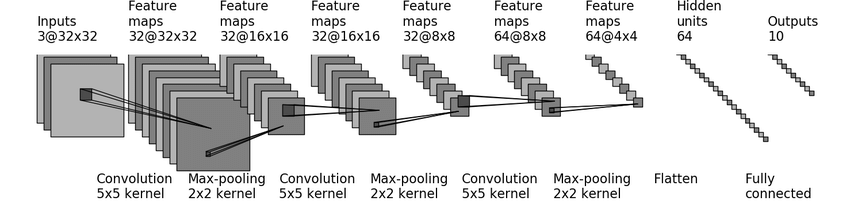

In [119]:
from models import CNN

cnn = CNN(INPUT_DIM, OUTPUT_DIM)
cnn = cnn.to(device)
count_model_params(cnn)

145578

In [120]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)

cnn_losses = train(cnn, NUM_EPOCHS, train_loader, device, criterion, optimizer)

Epoch 55 Iteration 49: loss 1.22794. : 100%|███████████████████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 10.87it/s]


Epoch 100 Iteration 49: loss 1.21006. : 100%|██████████████████████████████████████████████████████████████████████| 49/49 [00:04<00:00, 11.22it/s]


In [121]:
save_model_config(cnn)

saved to models/checkpoint_02-19_18-04-2025.pth


## Task 2 Analysis

  - Compare the performance of both models: investigate their learning curves (train/eval loss), compare their test accuracy, and compute their confusion matrix
  - Visualize some images, along with the predictions from your models. In what images do your models fail more often? Why do you think so?

#### MLP

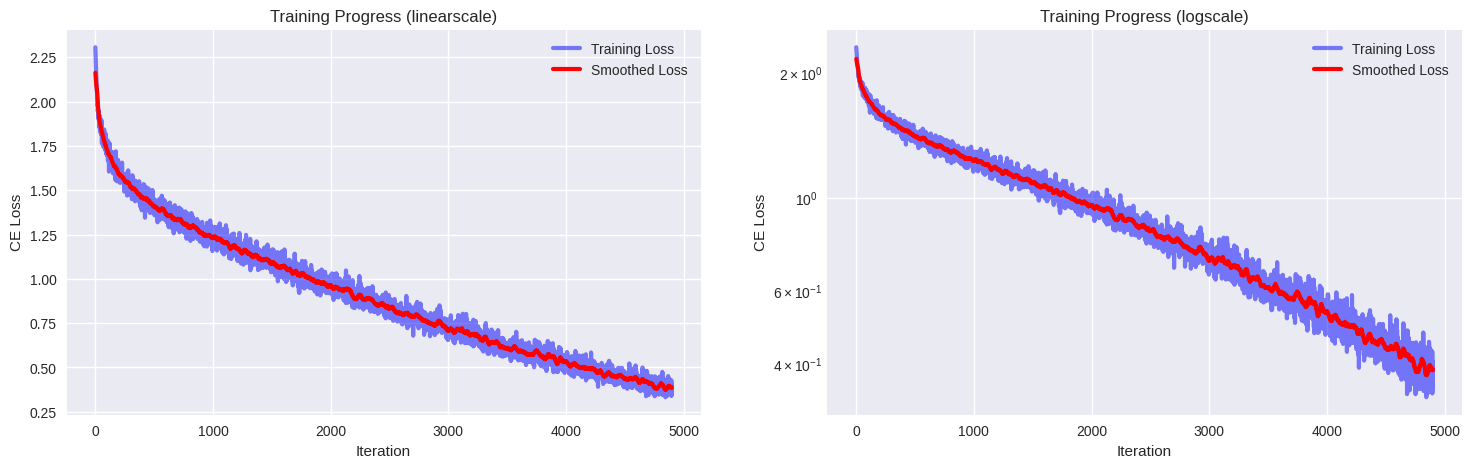

In [122]:
from visualize import plot_learning_curve

plot_learning_curve(mlp_losses)

In [123]:
from evaluate import evaluate
from torchmetrics.classification import MulticlassConfusionMatrix

confmat = MulticlassConfusionMatrix(num_classes=OUTPUT_DIM).to(device)
metrics = evaluate(mlp, eval_loader, device, confmat)

print(metrics)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.90it/s]

{'accuracy': 56.39999999999999, 'confusion_matrix': MulticlassConfusionMatrix()}


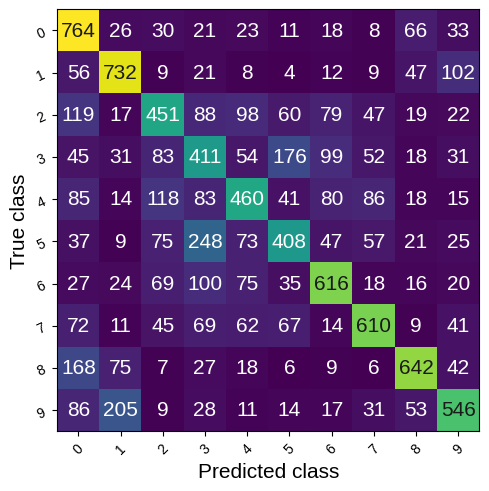

In [124]:
fig_, ax_ = metrics['confusion_matrix'].plot()

In [41]:
for class_count in range(OUTPUT_DIM):
    print(f"occurencies of label={class_count}: {eval_loader.dataset.targets.count(class_count)}")

occurencies of label=0: 1000
occurencies of label=1: 1000
occurencies of label=2: 1000
occurencies of label=3: 1000
occurencies of label=4: 1000
occurencies of label=5: 1000
occurencies of label=6: 1000
occurencies of label=7: 1000
occurencies of label=8: 1000
occurencies of label=9: 1000


The worst predictions are for class labels 3 and 4

In [ ]:
# TODO plot images

#### CNN

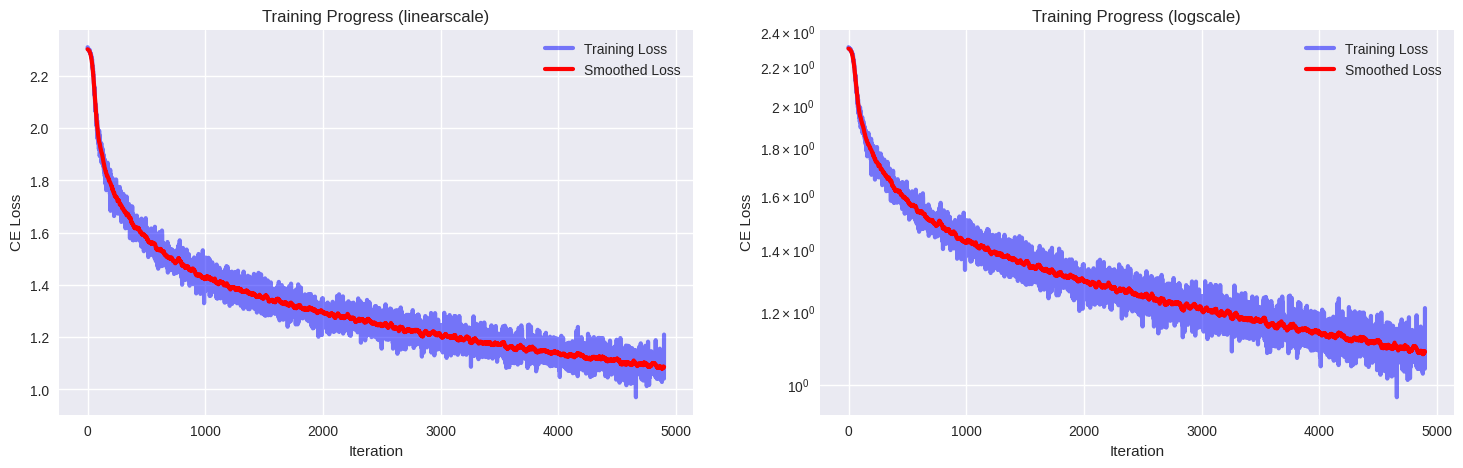

In [125]:
plot_learning_curve(cnn_losses)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.61it/s]


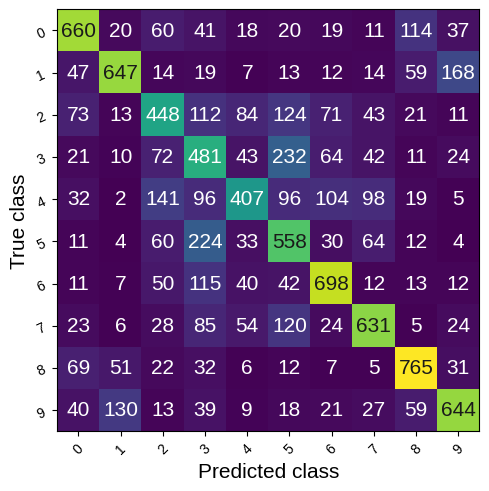

In [126]:
confmat = MulticlassConfusionMatrix(num_classes=OUTPUT_DIM).to(device)
metrics = evaluate(cnn, eval_loader, device, confmat)
fig_, ax_ = metrics['confusion_matrix'].plot()

## Task 3 Mitigate Overfitting

  - Train both models with and without DropOut. Compare the results: training and validation loss, accuracy, ...
  - Implement and use **your own** custom learning rate warmup and learning rate scheduler criterion to avoid overfitting.<br>
    It is not allowed to use PyTorch's schedulers, but you should code your own.<br>
    Train **one model** using it and show whether you can mitigate overfitting.

In [35]:
mlp_with_dropout = MLP(INPUT_DIM, hidden_dim, OUTPUT_DIM, True)
mlp_with_dropout = mlp_with_dropout.to(device)

mlp_with_dropout_criterion = nn.CrossEntropyLoss()
mlp_with_dropout_optimizer = torch.optim.Adam(mlp_with_dropout.parameters(), lr=LR)

mlp_with_dropout_losses = train(mlp_with_dropout, NUM_EPOCHS, train_loader,
                                device, mlp_with_dropout_criterion, mlp_with_dropout_optimizer)

Epoch 50 Iteration 49: loss 1.03289. : 100%|██████████| 49/49 [00:04<00:00, 12.03it/s]


In [36]:
confmat_with_dropout = MulticlassConfusionMatrix(num_classes=OUTPUT_DIM).to(device)
metrics_with_dropout = evaluate(mlp_with_dropout, eval_loader, device, confmat_with_dropout)

print(metrics_with_dropout)

100%|██████████| 10/10 [00:00<00:00, 12.48it/s]

{'accuracy': 54.48, 'confusion_matrix': MulticlassConfusionMatrix()}


In [37]:
mlp_without_dropout = MLP(INPUT_DIM, hidden_dim, OUTPUT_DIM, True)
mlp_without_dropout = mlp_without_dropout.to(device)

mlp_without_dropout_criterion = nn.CrossEntropyLoss()
mlp_without_dropout_optimizer = torch.optim.Adam(mlp_without_dropout.parameters(), lr=LR)

mlp_without_dropout_losses = train(mlp_without_dropout, NUM_EPOCHS, train_loader,
                                device, mlp_without_dropout_criterion, mlp_without_dropout_optimizer)

Epoch 50 Iteration 49: loss 0.94582. : 100%|██████████| 49/49 [00:04<00:00, 11.92it/s]


In [38]:
confmat_without_dropout = MulticlassConfusionMatrix(num_classes=OUTPUT_DIM).to(device)
metrics_without_dropout = evaluate(mlp_without_dropout, eval_loader, device, confmat_without_dropout)

print(metrics_without_dropout)

  0%|          | 0/10 [00:00<?, ?it/s]100%|██████████| 10/10 [00:00<00:00, 12.40it/s]

{'accuracy': 54.16, 'confusion_matrix': MulticlassConfusionMatrix()}


In [ ]:
# TODO own custom learning warmup